In [22]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
def data_transf_underlying(df_underlying_asset):
 df_underlying_transformed = df_underlying_asset[['Date ', 'close ']]
 df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
 df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
 return df_underlying_transformed

def simulate_stock_paths(S0, mu, sigma, T, M, I):
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        paths[t] = paths[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    return paths


def european_option_price(S0, K, T, r, sigma, M, I, option_type='call'):
    paths = simulate_stock_paths(S0, r, sigma, T, M, I)
    #Payoff at maturity
    if option_type == 'call':
        payoffs = np.maximum(paths[-1] - K, 0)
    else:
        payoffs = np.maximum(K - paths[-1], 0)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

def american_option_price(S0, K, T, r, sigma, M, I, option_type='call'):
    paths = simulate_stock_paths(S0, r, sigma, T, M, I)
    dt = T / M
    payoffs = np.maximum(0, paths[-1] - K if option_type == 'call' else K - paths[-1])
    cash_flows = np.zeros_like(payoffs)

    # Step backwards in time to estimate the optimal exercise strategy
    for t in range(M - 1, 0, -1):
        in_the_money = np.where(paths[t] > K if option_type == 'call' else paths[t] < K)
        regressor = np.polyfit(paths[t, in_the_money], payoffs[in_the_money] * np.exp(-r * dt), 2)
        continuation_value = np.polyval(regressor, paths[t])
        exercise_value = np.maximum(0, paths[t] - K if option_type == 'call' else K - paths[t])
        cash_flows[in_the_money] = np.where(exercise_value[in_the_money] > continuation_value[in_the_money], 
                                            exercise_value[in_the_money], cash_flows[in_the_money])
        payoffs = cash_flows * np.exp(-r * dt)

    option_price = np.exp(-r * dt) * np.mean(payoffs)
    return option_price

In [80]:
underlying_data = pd.read_csv(r"C:\Users\Admin\OneDrive\Desktop\Finsearch\Dataset\reliance_underlying_2023.csv")
underlying_data = data_transf_underlying(underlying_data)
close_price = underlying_data['close ']
close_price_rev = close_price[::-1]
S0 = 2318.15
T = 60
M = 60
I = 10
mu = ((2605.55 - 2318.15)/1000)
sigma = 0.189

C:\Users\Admin\AppData\Local\Temp\ipykernel_13332\3430764413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_13332\3430764413.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)


In [81]:
simulation = simulate_stock_paths(S0, mu, sigma, T, M, I)

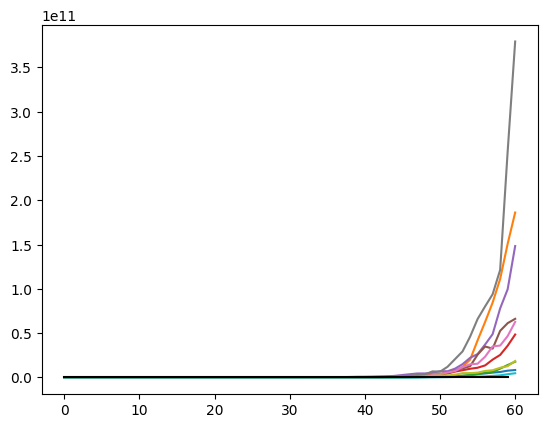

In [82]:
for i in range(I):
 plt.plot(np.arange(len(simulation[:, i])), simulation[:, i])

plt.plot(np.arange(60), close_price[59::-1], color = 'black')

    

In [83]:
european_option_price(S0, 2400, T, 0.07, sigma, M, I)

2502.1912491670255